## Initial Local Creation of Bayesian Network

## HC + BIC

The experimentation and testing of the initial simple Bayesian Network on a smaller dataset for testing

In [8]:
import pgmpy
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
import sys
sys.path.insert(0,"..")
from Data.DataPreprocessing import DataPreprocessing as myData
from pgmpy import estimators
from pgmpy.inference import VariableElimination
from sklearn.metrics import f1_score, accuracy_score, roc_curve, precision_score, recall_score, roc_auc_score, balanced_accuracy_score
from pgmpy.metrics import correlation_score, log_likelihood_score, structure_score


### Data importing and preprocessing

In [15]:
loaded_data = myData.load_data()

#display(loaded_data)
data = myData.preprocess_data(loaded_data)
train_data, test_data = myData.split_data(data,num_rows = 1000)

feature_states = myData.get_feature_states(data)
display(data)

c:\Users\zachs\Documents\CSHons\ResearchReport\Research_Code\Honours-Research\HC_differentScores\..\Data\DataPreprocessing.py:14: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../Data/accepted_2007_to_2018Q4.csv", engine='c')
c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_discretization.py:278: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(
c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_discretization.py:278: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn(
c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(esti

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,...,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort,total_bc_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,"(961.0, 8800.0]",36 months,"(10.446, 15.582]","(5.898, 350.054]",C,10+ years,MORTGAGE,0.0,Not Verified,Dec-2015,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,N,Cash,N
1,"(24400.0, 32200.0]",36 months,"(10.446, 15.582]","(692.498, 1034.942]",C,10+ years,MORTGAGE,0.0,Not Verified,Dec-2015,...,0.0,4.0,0.0,0.0,0.0,1.0,3.0,N,Cash,N
2,"(16600.0, 24400.0]",60 months,"(10.446, 15.582]","(350.054, 692.498]",B,10+ years,MORTGAGE,0.0,Not Verified,Dec-2015,...,0.0,4.0,2.0,0.0,0.0,0.0,0.0,N,Cash,N
4,"(8800.0, 16600.0]",60 months,"(20.718, 25.854]","(5.898, 350.054]",F,3 years,MORTGAGE,0.0,Source Verified,Dec-2015,...,1.0,4.0,2.0,0.0,0.0,2.0,1.0,N,Cash,N
5,"(8800.0, 16600.0]",36 months,"(10.446, 15.582]","(350.054, 692.498]",C,4 years,RENT,0.0,Source Verified,Dec-2015,...,0.0,4.0,4.0,0.0,0.0,0.0,0.0,N,Cash,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260688,"(16600.0, 24400.0]",60 months,"(5.284, 10.446]","(350.054, 692.498]",B,5 years,OWN,0.0,Not Verified,Oct-2016,...,0.0,4.0,1.0,0.0,0.0,1.0,0.0,N,Cash,N
2260690,"(24400.0, 32200.0]",60 months,"(10.446, 15.582]","(350.054, 692.498]",C,9 years,MORTGAGE,1.0,Not Verified,Oct-2016,...,0.0,4.0,2.0,0.0,0.0,2.0,2.0,N,Cash,N
2260691,"(24400.0, 32200.0]",60 months,"(10.446, 15.582]","(692.498, 1034.942]",C,3 years,MORTGAGE,1.0,Source Verified,Oct-2016,...,0.0,4.0,0.0,0.0,0.0,2.0,0.0,N,Cash,N
2260692,"(8800.0, 16600.0]",60 months,"(10.446, 15.582]","(350.054, 692.498]",C,10+ years,RENT,1.0,Not Verified,Oct-2016,...,0.0,3.0,2.0,1.0,0.0,1.0,0.0,N,Cash,N


### Structure Learning

In [10]:
scoring_method = estimators.BicScore(data=train_data)
est = estimators.HillClimbSearch(data=train_data, use_cache = True)
estimated_model = est.estimate(
    scoring_method=scoring_method, max_iter=int(1e2))

model = pgmpy.models.BayesianNetwork(estimated_model.edges())
model.add_nodes_from(estimated_model.nodes())
#print(len(model.nodes()))
#print(model.edges())



 71%|███████   | 71/100 [00:20<00:08,  3.44it/s]


88
58


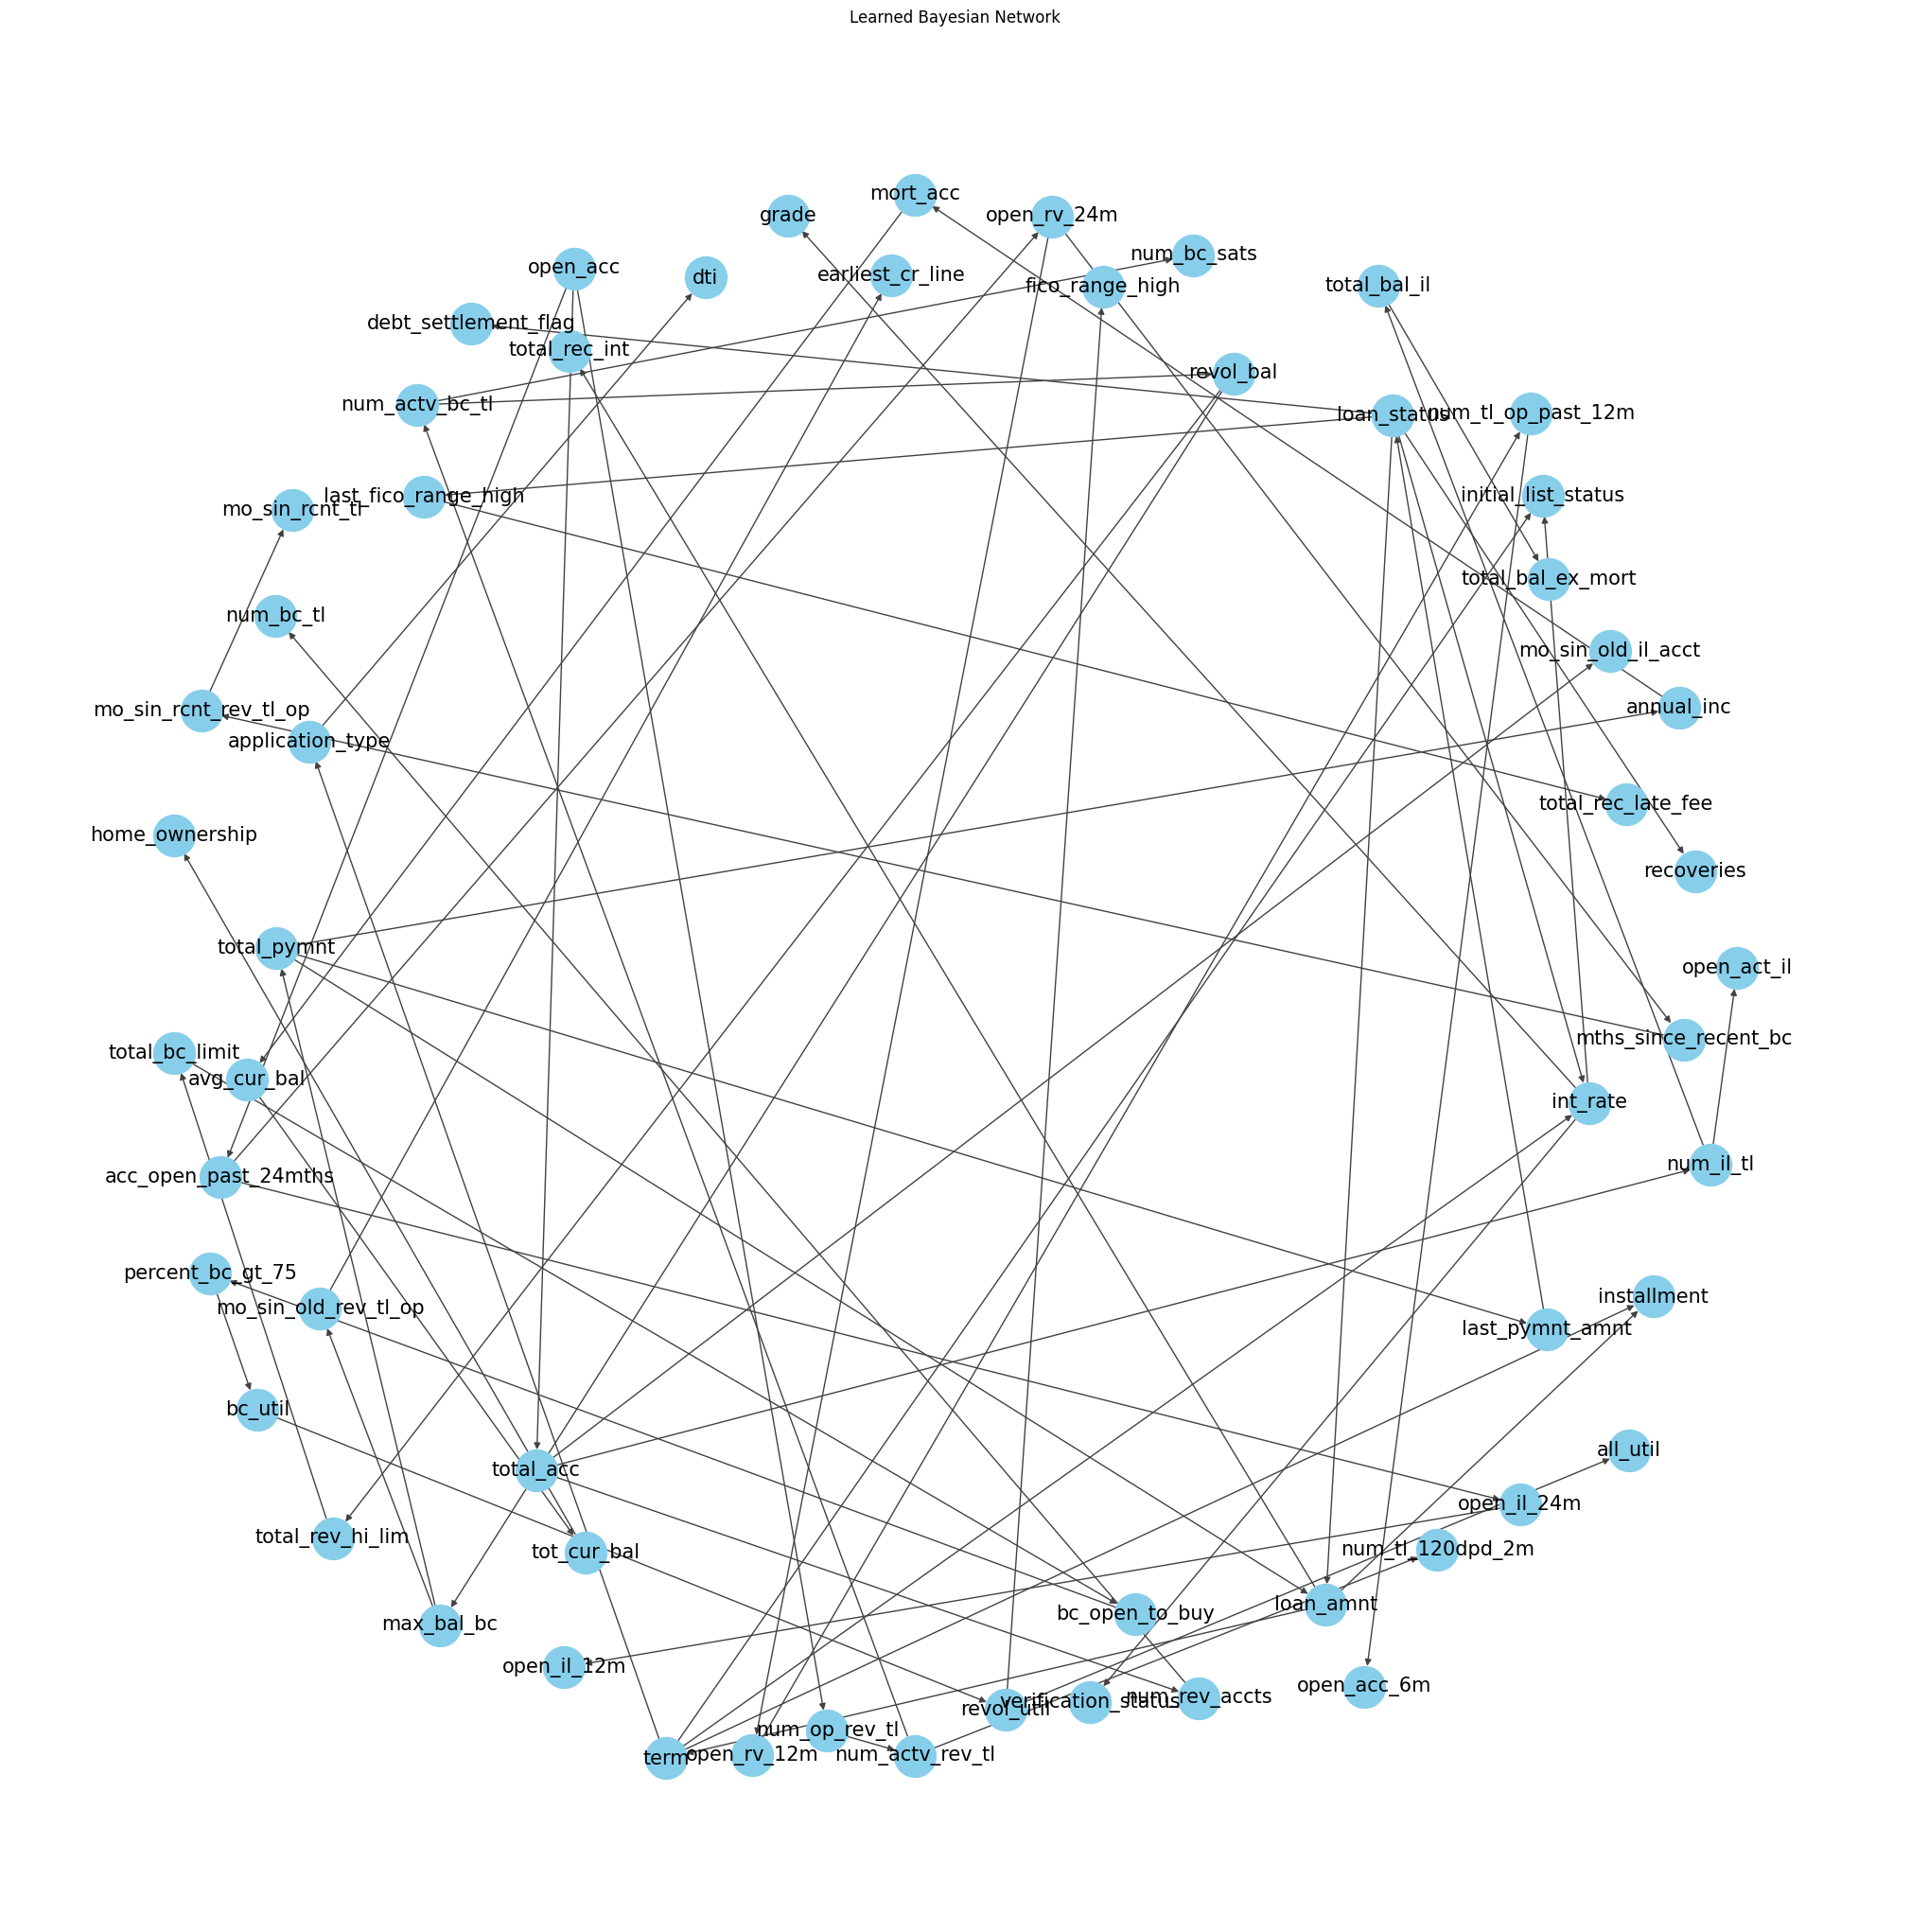

In [11]:
active_trail_nodes = model.active_trail_nodes('loan_status')['loan_status']
active_trail_nodes_list = list(active_trail_nodes)
original_nodes = list(model.nodes())
for node in original_nodes:
    if node not in active_trail_nodes_list:
        model.remove_node(node)
print(len(feature_states))
print(len(model.nodes()))

nx_graph = nx.DiGraph(model.edges())
pos = nx.spring_layout(nx_graph,2)
plt.figure(figsize=(20, 20))
nx.draw(nx_graph, pos, with_labels=True, node_size=1000, node_color = 'skyblue', edge_color='#424242',font_size=15,font_color='black')
plt.title('Learned Bayesian Network')
plt.show()

###  Parameter Estimation

In [12]:
parameter_estimator = estimators.BayesianEstimator(model,train_data, state_names = feature_states)
parameters = parameter_estimator.get_parameters(n_jobs=6)

for i in range(len(parameters)):
    model.add_cpds(parameters[i])
    #print(parameters[i])

model.states

{'loan_amnt': ['(961.0, 8800.0]',
  '(24400.0, 32200.0]',
  '(16600.0, 24400.0]',
  '(8800.0, 16600.0]',
  '(32200.0, 40000.0]'],
 'loan_status': ['Fully Paid', 'Charged Off'],
 'total_pymnt': ['0.0', '3.0', '2.0', '1.0', '4.0'],
 'installment': ['(5.898, 350.054]',
  '(692.498, 1034.942]',
  '(350.054, 692.498]',
  '(1034.942, 1377.386]',
  '(1377.386, 1719.83]'],
 'term': [' 36 months', ' 60 months'],
 'total_rec_int': ['0.0', '1.0', '2.0', '3.0', '4.0'],
 'int_rate': ['(10.446, 15.582]',
  '(20.718, 25.854]',
  '(5.284, 10.446]',
  '(15.582, 20.718]',
  '(25.854, 30.99]'],
 'application_type': ['Individual', 'Joint App'],
 'initial_list_status': ['w', 'f'],
 'grade': ['C', 'B', 'F', 'A', 'E', 'D', 'G'],
 'verification_status': ['Not Verified', 'Source Verified', 'Verified'],
 'annual_inc': ['0.0', '1.0', '2.0', '4.0', '3.0'],
 'mort_acc': ['0.0', '1.0', '2.0', '3.0', '4.0'],
 'last_pymnt_amnt': ['0.0', '2.0', '1.0', '3.0', '4.0'],
 'last_fico_range_high': ['(510.0, 680.0]',
  '(680.

### Inference

In [13]:
def performInference(target_label):
    y_pred = []
    y_true = []    
    testing_evidence_list = myData.get_evidence_list(test_data, target_label=target_label)
    inference = VariableElimination(model)
    for i in range(len(testing_evidence_list)):
        for attribute in list(testing_evidence_list[i].keys()):
            if attribute not in model.nodes():
                del testing_evidence_list[i][attribute]
                
    for i in range(len(testing_evidence_list)):
        loan_status = inference.map_query([target_label], evidence = testing_evidence_list[i], show_progress= True) 
        y_pred.append(loan_status[target_label])
        y_true.append(test_data[target_label].iloc[i])
    
    return y_pred, y_true
    
loan_status_y_pred, loan_status_y_true = performInference('loan_status')    


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it

## Testing

In [14]:
def testModel(y_true, y_pred):
    data_testing_corr_score = model.simulate(int(1e4))
    correlation_score_value = correlation_score(model, data_testing_corr_score, test="log_likelihood", significance_level=0.05)
    log_likelihood_score_value = log_likelihood_score(model, data_testing_corr_score)
    structure_score_value = structure_score(model, data_testing_corr_score, scoring_method="bic")
    print("correlation score: " + str(correlation_score_value))
    print("Log likelihood score: " + str(log_likelihood_score_value))
    print("Structure score: "+ str(structure_score_value))

    accuracy_score_value = accuracy_score(y_true, y_pred)
    f1score_value = f1_score(y_true, y_pred, average = None)
    precisionScore = precision_score(y_true, y_pred,average = None)
    recallScore = recall_score(y_true, y_pred,average = None)
    #roc_auc_score_value =  roc_auc_score(y_true, y_pred,average = None)
    balanced_accuracy_score_value = balanced_accuracy_score(y_true, y_pred, adjusted=True)

    f1_score_macro = f1_score(y_true, y_pred, average='macro')
    precision_score_macro = precision_score(y_true, y_pred, average='macro')
    recall_score_macro = recall_score(y_true, y_pred, average='macro')

    f1_score_weighted = f1_score(y_true, y_pred, average = 'weighted')
    precision_score_weighted = precision_score(y_true, y_pred, average = 'weighted')
    recall_score_weighted = recall_score(y_true, y_pred, average = 'weighted')

    print("accuracy score: "+str(accuracy_score_value))
    print("f1_score: "+str(f1score_value))
    print("precision score: "+str(precisionScore))
    print("recall score: "+str(recallScore))
    #print("roc auc score: "+str(roc_auc_score_value))
    print("balanced_accuracy_score: " + str(balanced_accuracy_score_value))
    print("\n\n")
    print("Macro scores:\n")
    print("recall_score_macro: "+str(recall_score_macro))
    print("f1_score_macro: "+str(f1_score_macro))
    print("precision_score_macro: "+str(precision_score_macro))
    print("\n")
    print("Weighted Scores:\n")
    print("recall_score_weighted: "+str(recall_score_weighted))
    print("f1_score_weighted: "+str(f1_score_weighted))
    print("precision_score_weighted: "+str(precision_score_weighted))
    
    
testModel(loan_status_y_true, loan_status_y_pred)

Generating for node: dti: 100%|██████████| 58/58 [00:00<00:00, 188.77it/s]
c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)


correlation score: 0.0
Log likelihood score: -430350.84402753075
Structure score: -436117.2059416141
accuracy score: 0.972
f1_score: [0.94117647 0.9816273 ]
precision score: [0.98245614 0.96891192]
recall score: [0.90322581 0.99468085]
balanced_accuracy_score: 0.8979066575154426



Macro scores:

recall_score_macro: 0.9489533287577213
f1_score_macro: 0.9614018835880809
precision_score_macro: 0.9756840287246613


Weighted Scores:

recall_score_weighted: 0.972
f1_score_weighted: 0.971595491740003
precision_score_weighted: 0.9722708844650486
